In [1]:
#AIbolit is the name of the project, SMOTE is Synthetic Minority Oversampling Technique 
#for working with unbalanced data

#Several datasets have been collected here for diseases such as lung cancer,
#stroke and stroke after oncopathology
#I will try to describe each step, let's go!

from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from statistics import mean
from sklearn.utils import shuffle
import seaborn as sns
from matplotlib import pyplot as plt
import os,sys

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#CANCER & STROKE
#Let's start with predictions of stroke and oncopathology
#All patients from the sick_patients sample have a documented stroke after oncopathology
healthy_patients = pd.read_excel('../input/covid19/dataset.xlsx',engine="openpyxl")
sick_patients = pd.read_excel('/kaggle/input/medicine-data/Stroke and Canser predict.xlsx',engine="openpyxl")

In [3]:
healthy_patients.head()

,Patient ID,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,...,Hb saturation (arterial blood gases),pCO2 (arterial blood gas analysis),Base excess (arterial blood gas analysis),pH (arterial blood gas analysis),Total CO2 (arterial blood gas analysis),HCO3 (arterial blood gas analysis),pO2 (arterial blood gas analysis),Arteiral Fio2,Phosphor,ctO2 (arterial blood gas analysis)
0,44477f75e8169d2,13,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,126e9dd13932f68,17,negative,0,0,0,0.236515,-0.02234,-0.517413,0.010677,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,a46b4402a0e5696,8,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,f7d619a94f97c45,5,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,d9e41465789c2b5,15,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
sick_patients.head()

,Hemoglobin,Hematocrit,Leukocytes,Red blood Cells,Mean corpuscular volume (MCV),Red blood cell distribution width (RDW),Platelets,International normalized ratio (INR),Partial thromboplastin time\xa0(PTT)\xa0,"'Prothrombin time (PT), Activity"
0,149,42.5,7.41,4.95,85.9,NaN,186,1.00,27.0,NaN
1,77,25.2,5.23,2.97,NaN,NaN,127,1.08,26.0,16.0
2,143,46.2,4.07,4.85,95.2,55.2,193,0.89,26.0,14.0
3,93,29.8,15.07,3.35,88.9,65.1,89,1.45,38.0,19.7
4,134,39.0,5.14,4.65,83.9,47.2,173,1.34,30.2,16.2


In [5]:
#We take only those parameters that are contained in the sick_patients dataset
healthy_patients = healthy_patients[['Hemoglobin', 'Hematocrit', 'Leukocytes', 'Red blood Cells', 'Mean corpuscular volume (MCV)', 'Red blood cell distribution width (RDW)', 'Platelets']]
healthy_patients = healthy_patients.dropna ()

In [6]:
#A little preprocessing
sick_patients = sick_patients.round(2)
sick_patients = sick_patients.fillna(sick_patients.mean())
sick_patients = (sick_patients-sick_patients.mean())/sick_patients.std()
sick_patients['Strock'] = 1

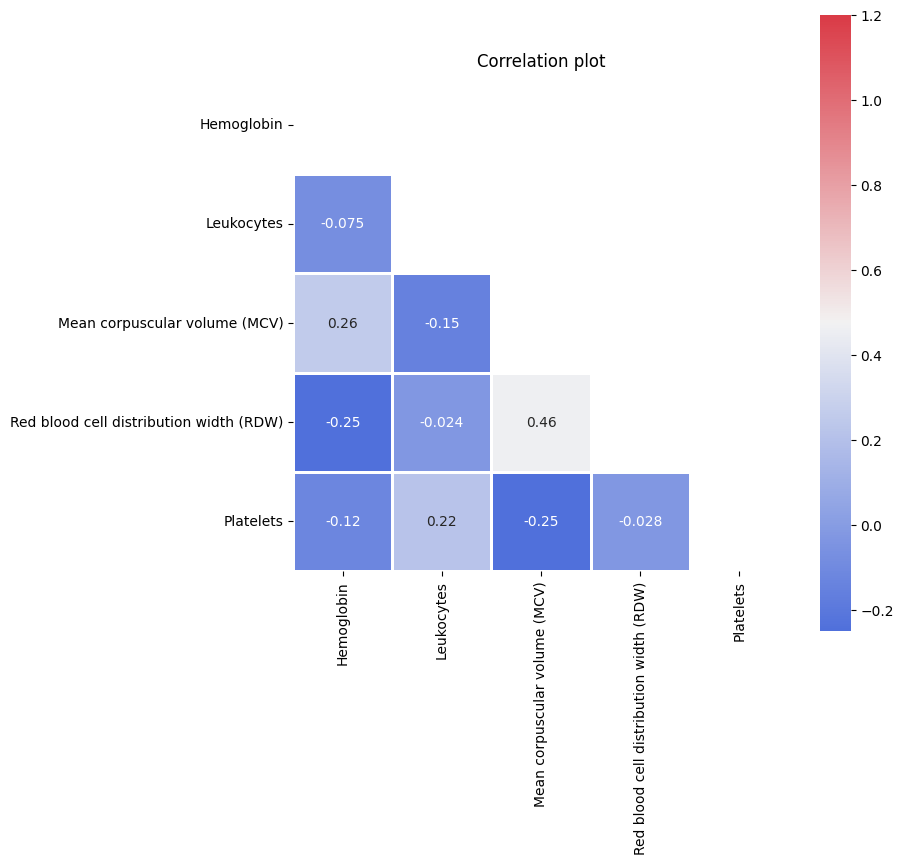

In [7]:
#Let's see how our parameters look on the correlation matrix
best_features_ever = ['Hemoglobin', 'Leukocytes', 'Mean corpuscular volume (MCV)', 'Red blood cell distribution width (RDW)', 'Platelets']
corr = sick_patients.loc[:, best_features_ever].corr()

mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
data, ax = plt.subplots(figsize=(8, 8))
plt.title('Correlation plot')
cmap = sns.diverging_palette(260, 10, as_cmap=True)

sns.heatmap(corr, vmax=1.2, square='square', cmap=cmap, mask=mask, 
            ax=ax, annot=True, fmt='.2g',linewidths=2);

In [8]:
healthy_patients['Strock'] = 0
sick_patients = sick_patients.round(5)
healthy_patients = healthy_patients.round(5)

In [9]:
#Combining datasets for training
data = pd.concat([healthy_patients, sick_patients], axis=0)
data = data[['Hemoglobin', 'Leukocytes', 'Mean corpuscular volume (MCV)',
             'Red blood cell distribution width (RDW)', 'Platelets', 'Strock']]
data = shuffle(data)

X = data.drop(['Strock'], axis=1)
y = data['Strock']

In [10]:
#Use SMOTE to oversample the minority class
oversample = SMOTE()
over_X, over_y = oversample.fit_resample(X, y)
over_X_train, over_X_test, over_y_train, over_y_test = train_test_split(over_X, over_y, test_size=0.1, stratify=over_y)
#Build SMOTE SRF model
SMOTE_SRF = RandomForestClassifier(n_estimators=160)
#Create Stratified K-fold cross validation
c = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)
s = ('f1', 'recall', 'precision')

In [11]:
#Evaluate SMOTE SRF model
scoring = cross_validate(SMOTE_SRF, over_X, over_y, scoring=s, cv=c)
#Get average evaluation metrics
print('Mean f1: %.3f' % mean(scoring['test_f1']))
print('Mean recall: %.3f' % mean(scoring['test_recall']))
print('Mean precision: %.3f' % mean(scoring['test_precision']))

Mean f1: 0.855
Mean recall: 0.872
Mean precision: 0.840


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
SMOTE_SRF.fit(over_X_train, over_y_train)

RandomForestClassifier(n_estimators=160)

In [13]:
y_pred = SMOTE_SRF.predict(X_test)
y_pred[0]

0

In [14]:
#I prefer _proba because you can't say sick person or not without a doctor's appointment
y_pred_proba = SMOTE_SRF.predict_proba(X_test)
y_pred_proba[0]

array([0.9625, 0.0375])

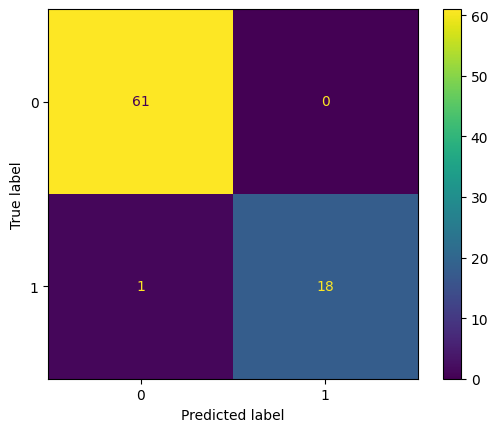

In [15]:
#Create confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=SMOTE_SRF.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=SMOTE_SRF.classes_)
disp.plot()
plt.show()

In [16]:
#LUNG
#Let's continue working with lung cancer and do everything by analogy
lung_data = pd.read_csv("/kaggle/input/lung-cancer/survey lung cancer.csv")

In [17]:
#There are always fewer sick patients than healthy ones
lung_data['LUNG_CANCER'].value_counts()

YES    270
NO      39
Name: LUNG_CANCER, dtype: int64

In [18]:
lung_data.head()

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,M,69,1,2,2,1,1,2,1,2,2,2,2,2,2,YES
1,M,74,2,1,1,1,2,2,2,1,1,1,2,2,2,YES
2,F,59,1,1,1,2,1,2,1,2,1,2,2,1,2,NO
3,M,63,2,2,2,1,1,1,1,1,2,1,1,2,2,NO
4,F,63,1,2,1,1,1,1,1,2,1,2,2,1,1,NO


In [19]:
encoder = LabelEncoder()
lung_data['LUNG_CANCER']=encoder.fit_transform(lung_data['LUNG_CANCER'])
lung_data['GENDER']=encoder.fit_transform(lung_data['GENDER'])
lung_data = lung_data[['GENDER', 'AGE', 'SMOKING', 'CHRONIC DISEASE', 'ALLERGY ', 'WHEEZING',
       'ALCOHOL CONSUMING', 'COUGHING', 'SHORTNESS OF BREATH',
       'SWALLOWING DIFFICULTY', 'CHEST PAIN', 'LUNG_CANCER']]

lung_data.drop_duplicates(inplace=True)

In [20]:
X_lung = lung_data.drop(['LUNG_CANCER'], axis=1)
y_lung = lung_data['LUNG_CANCER']

In [21]:
oversample_lung = SMOTE()
over_X_lung, over_y_lung = oversample_lung.fit_resample(X_lung, y_lung)
over_X_train_lung, over_X_test_lung, over_y_train_lung, over_y_test_lung = train_test_split(over_X_lung, over_y_lung, test_size=0.1, stratify=over_y_lung)
SMOTE_SRF_lung = RandomForestClassifier(n_estimators=60)
cv_lung = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)

In [22]:
scoring_lung = cross_validate(SMOTE_SRF_lung, over_X_lung, over_y_lung, scoring=s, cv=cv_lung)
print('Mean f1: %.3f' % mean(scoring_lung['test_f1']))
print('Mean recall: %.3f' % mean(scoring_lung['test_recall']))
print('Mean precision: %.3f' % mean(scoring_lung['test_precision']))

Mean f1: 0.933
Mean recall: 0.939
Mean precision: 0.930


In [23]:
X_train_lung, X_test_lung, y_train_lung, y_test_lung = train_test_split(X_lung, y_lung, test_size=0.1, stratify=y_lung)
SMOTE_SRF.fit(over_X_train_lung, over_y_train_lung)
y_pred_lung = SMOTE_SRF.predict_proba(X_test_lung)

In [24]:
y_pred_lung[0]

array([0.2375, 0.7625])

In [25]:
#STROKE
#Using SMOTE for the third dataset
stroke_data = pd.read_csv('/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv')

In [26]:
stroke_data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [27]:
stroke_data = stroke_data[['gender','age', 'hypertension', 'heart_disease','avg_glucose_level','smoking_status','stroke']]

In [28]:
#Bring the data to a convenient form
stroke_data = stroke_data.replace("Female", "0")
stroke_data = stroke_data.replace("Male", "1")
stroke_data = stroke_data.replace("Other", "1")
stroke_data = stroke_data[stroke_data["smoking_status"].str.contains("Unknown")== False]
stroke_data['smoking_status'] = encoder.fit_transform(stroke_data['smoking_status'])

In [29]:
stroke_data['stroke'].value_counts()

0    3364
1     202
Name: stroke, dtype: int64

In [30]:
X_stroke = stroke_data.drop(['stroke'], axis=1)
y_stroke = stroke_data['stroke']

In [31]:
oversample_stroke = SMOTE()
over_X_stroke, over_y_stroke = oversample_stroke.fit_resample(X_stroke, y_stroke)
over_X_train_stroke, over_X_test_stroke, over_y_train_stroke, over_y_test_stroke = train_test_split(over_X_stroke, over_y_stroke, test_size=0.1, stratify=over_y_stroke)
SMOTE_SRF_stroke = RandomForestClassifier(n_estimators=150)
cv_stroke = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)

In [32]:
scoring_stroke = cross_validate(SMOTE_SRF_stroke, over_X_stroke, over_y_stroke, scoring=s, cv=cv_stroke)
print('Mean f1: %.3f' % mean(scoring_stroke['test_f1']))
print('Mean recall: %.3f' % mean(scoring_stroke['test_recall']))
print('Mean precision: %.3f' % mean(scoring_stroke['test_precision']))

Mean f1: 0.932
Mean recall: 0.933
Mean precision: 0.931


In [33]:
#SMOTE works great for medical datasets
X_train_stroke, X_test_stroke, y_train_stroke, y_test_stroke = train_test_split(X_stroke, y_stroke, test_size=0.1, stratify=y_stroke)
SMOTE_SRF_stroke.fit(over_X_train_stroke, over_y_train_stroke)
y_pred_stroke = SMOTE_SRF_stroke.predict_proba(X_test_stroke)
y_pred_stroke[0]

array([0.96666667, 0.03333333])